In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as pl

import jax.numpy as np
import jax
from jax.test_util import check_grads

import nfjax

keys = jax.random.split(jax.random.PRNGKey(0), 10)
nn = 84
weights = np.abs(jax.random.normal (keys[0], (nn, nn)))+0.5
lengths = jax.random.randint(keys[1], (nn, nn), 0, 255)
nh = lengths.max() + 1
nt = 100
buffer = jax.random.normal(keys[2], (nn, nh + nt))
nn = weights.shape[0]
ns = np.tile(np.arange(nn),(nn,1))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


** shtns is not available


In [2]:
ts = np.r_[:1000]
dt = 0.1
p = -0.9

28.4 ms ± 3.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


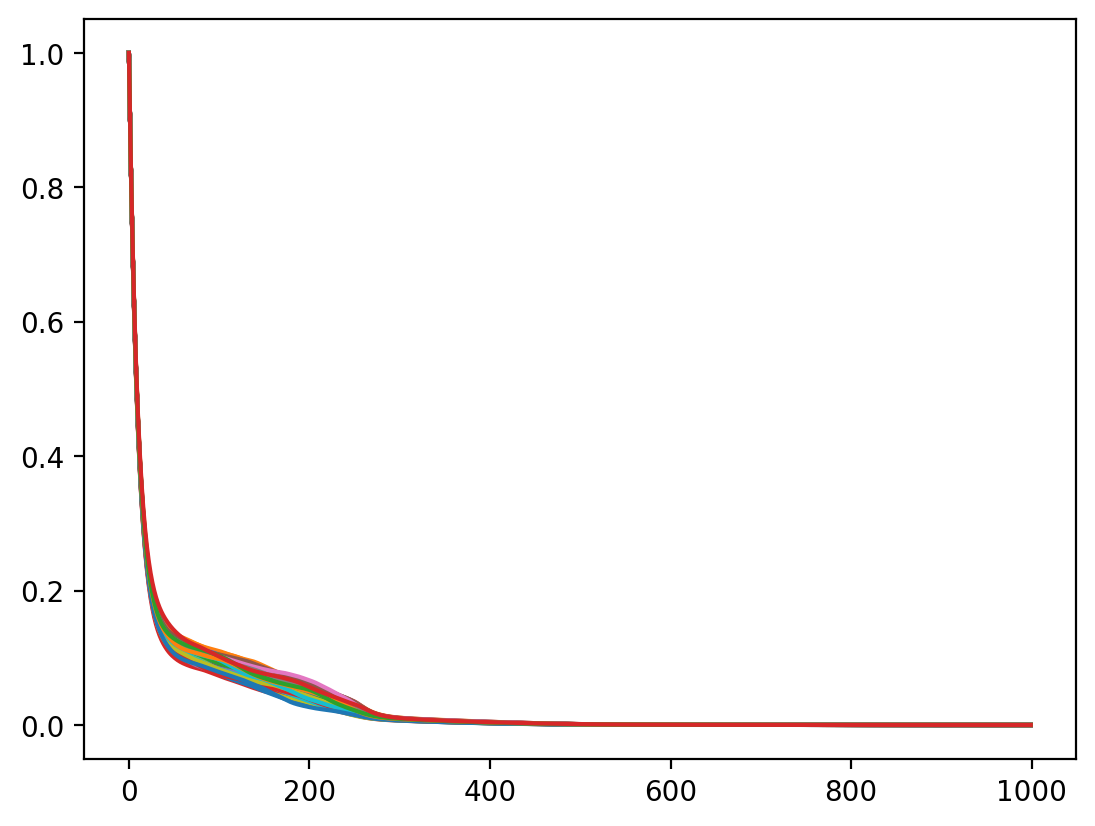

In [3]:
cfun = lambda xt, t: 0.1*np.mean(weights*xt[ns, nh + t - lengths], axis=1)
dfun = lambda xt, x, t, p: p*x + cfun(xt,t)
_, loop = nfjax.make_dde(dt, nh, dfun)

xt = np.ones((nn, nh + ts.size))
xt1 = loop(xt, ts, -1.0)
%timeit loop(xt, ts, -1.0)
pl.plot(xt1[:, nh:].T);

no delays, using make_ode instead
7.57 ms ± 515 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


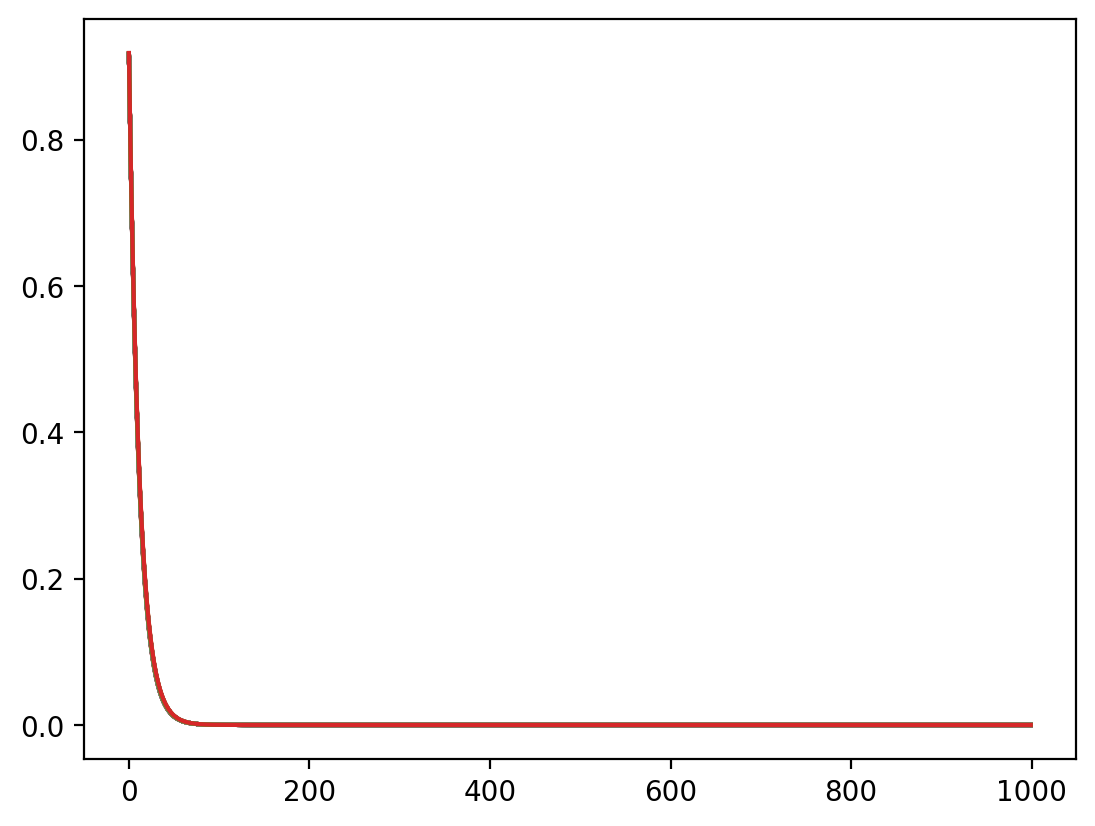

In [8]:
# same thing no delays
def dfun(xt, x, t, p):
    cx = 0.1*np.mean(weights*x, axis=1)
    return p*x + cx

nh = 0
_, loop = nfjax.make_dde(dt, nh, dfun)

xt = np.ones((nn, ts.size))
xt1 = loop(xt, ts, -1.0)
%timeit loop(xt, ts, -1.0)
pl.plot(xt1[:, nh:].T);

So that's without delays in the dfun but compared to simpler `make_ode` there's still an overhead,

In [ ]:
# same thing no delays, with make_ode
def dfun(x, p):
    cx = 0.1*np.mean(weights*x, axis=1)
    return p*x + cx

_, loop = nfjax.make_ode(dt, dfun)

xt = np.ones((nn,))
xt1 = loop(xt, ts, -1.0)
%timeit loop(xt, ts, -1.0)
pl.plot(xt1);

In [33]:
def dfun(xt, x, t, p):
    xd = xt[0, t-100]
    dx = x - x**3/3 + p*xt[0, t-100]
    return dx

_, loop = nfjax.make_dde(0.1, 101, dfun)
key = jax.random.PRNGKey(42)
xt = jax.random.normal(key, (1, 200))
xt1 = loop(xt, np.r_[:100], 0.2)

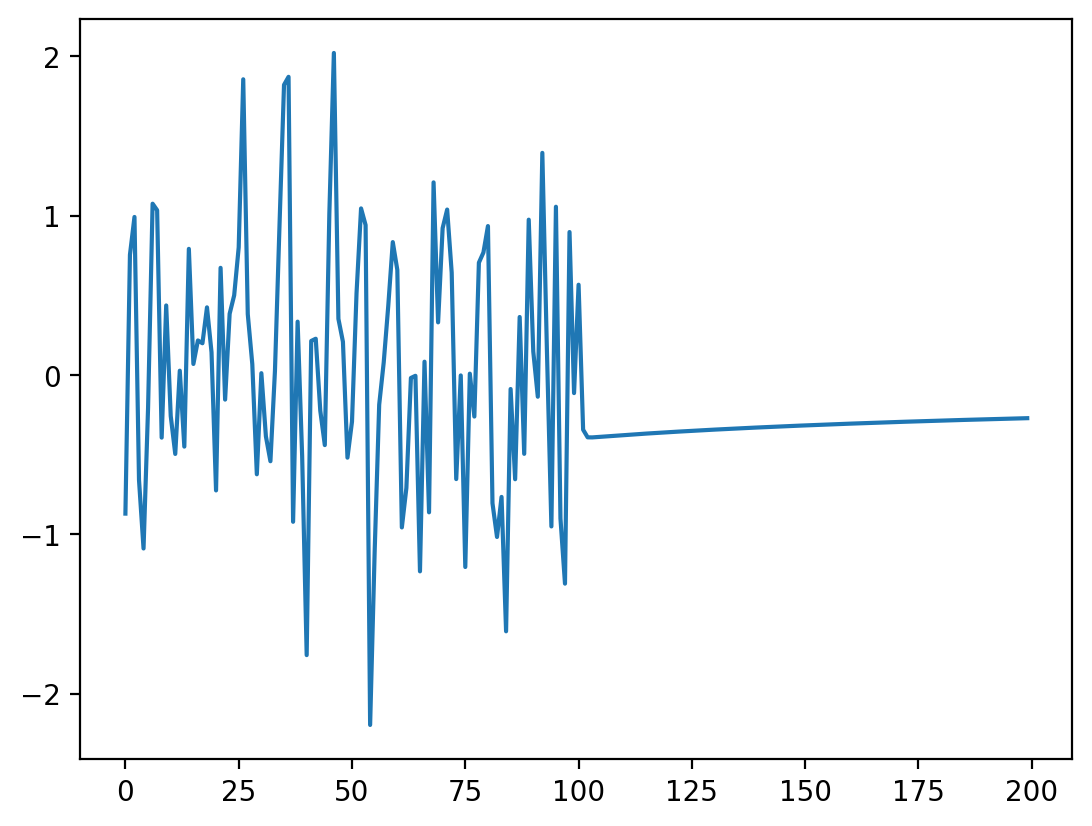

In [34]:
xt1 = loop(xt, np.r_[:100], -1.0)
pl.plot(xt1[0])